<a href="https://colab.research.google.com/github/FuturisticLover123/learning/blob/main/DataAnalys/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install catboost
!pip install SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

import optuna

import pandas as pd


In [ ]:
data = pd.read_csv("/content/data.csv")
X, y = data.drop(columns = ["out"]), data["out"]
scaler = StandardScaler()
X_scalled = pd.DataFrame(scaler.fit_transform(X))


X_train, X_test, y_train, y_test = train_test_split(X_scalled, y, test_size=0.2)

In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 50),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_pool = Pool(X_tr, y_tr)
        val_pool = Pool(X_val, y_val)

        model = CatBoostRegressor(**params, verbose=0)
        model.fit(train_pool, eval_set=val_pool)

        y_pred = model.predict(X_val)
        scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=3600)

[I 2025-05-10 12:34:39,623] A new study created in memory with name: no-name-742c9ed5-ab75-4b04-9336-5563d3b42cc0
[I 2025-05-10 12:34:41,081] Trial 0 finished with value: 0.20790610680079952 and parameters: {'iterations': 660, 'learning_rate': 0.17976839800744948, 'depth': 8, 'l2_leaf_reg': 0.1605505632563728, 'random_strength': 9.740336444116393, 'bagging_temperature': 0.4221120228512185, 'min_data_in_leaf': 77, 'grow_policy': 'SymmetricTree', 'early_stopping_rounds': 25}. Best is trial 0 with value: 0.20790610680079952.
[I 2025-05-10 12:34:41,776] Trial 1 finished with value: 0.20747636707389341 and parameters: {'iterations': 190, 'learning_rate': 0.07674180246596768, 'depth': 9, 'l2_leaf_reg': 2.2983655654287847, 'random_strength': 1.3631529932843667, 'bagging_temperature': 0.4998869257636692, 'min_data_in_leaf': 99, 'grow_policy': 'Lossguide', 'early_stopping_rounds': 38}. Best is trial 1 with value: 0.20747636707389341.
[I 2025-05-10 12:34:43,288] Trial 2 finished with value: 0.21

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
final_model = CatBoostRegressor(**study.best_params,  verbose=100)
final_model.fit(
    Pool(X_train, y_train),
    eval_set=Pool(X_val, y_val),
    early_stopping_rounds=50
)

0:	learn: 0.9982008	test: 0.9322429	best: 0.9322429 (0)	total: 894us	remaining: 494ms
100:	learn: 0.2234304	test: 0.2470821	best: 0.2470821 (100)	total: 37.4ms	remaining: 167ms
200:	learn: 0.1599988	test: 0.2115295	best: 0.2113581 (195)	total: 73.7ms	remaining: 129ms
300:	learn: 0.1169011	test: 0.2079404	best: 0.2054408 (260)	total: 106ms	remaining: 89.1ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2054407602
bestIteration = 260

Shrink model to first 261 iterations.


In [ ]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('model', final_model)
])

In [ ]:
r2_score(pipeline.predict(X), y)

0.9670895969753651

In [ ]:
_ = pd.concat([data.min(axis=0), data.max(axis=0)], axis=1)
ranges = dict(zip(_.index, _[[0, 1]].apply(tuple, axis=1)))
ranges.pop('out');

In [ ]:
ranges

{'val1': (-2.5155084151391285, 2.065079170072512),
 'val2': (-2.5155084151391285, 2.065079170072512),
 'val3': (-2.5155084151391285, 2.065079170072512),
 'val4': (-2.5155084151391285, 2.065079170072512),
 'val5': (-2.5155084151391285, 2.065079170072512)}

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple




def generate_morris_trajectories(ranges,
                                n_trajectories: int = 10,
                                delta_ratio: float = 0.2):
    trajectories = []
    n_params = len(ranges)

    for _ in range(n_trajectories):
        base_point = {p: np.random.uniform(low, high) for p, (low, high) in ranges.items()}
        trajectory = [base_point]

        for param in ranges:
            new_point = base_point.copy()
            delta = delta_ratio * (ranges[param][1] - ranges[param][0])
            new_point[param] += delta

            trajectory.append(new_point)

        trajectories.append(trajectory)

    return trajectories

def calculate_elementary_effects(model,
                               trajectories,
                               ranges,
                               delta_ratio: float = 0.2):
    ee_results = {param: [] for param in ranges}

    for trajectory in trajectories:
        base_point = trajectory[0]
        base_pred = model.predict([list(base_point.values())])[0]

        for i, param in enumerate(ranges):
            perturbed_point = trajectory[i+1]
            perturbed_pred = model.predict([list(perturbed_point.values())])[0]

            delta = delta_ratio * (ranges[param][1] - ranges[param][0])
            ee = (perturbed_pred - base_pred) / delta

            ee_results[param].append(ee)

    return ee_results


def morris_analysis_plot(ee_results):
    mu = {p: np.mean(effects) for p, effects in ee_results.items()}
    sigma = {p: np.std(effects) for p, effects in ee_results.items()}

    params = list(mu.keys())
    x_pos = np.arange(len(params))

    plt.figure(figsize=(10, 6))
    plt.bar(x_pos, mu.values(), yerr=sigma.values(), capsize=5, alpha=0.7, color='skyblue')
    plt.xticks(x_pos, params, rotation=45)
    plt.xlabel('Параметры')
    plt.ylabel('Средний элементарный эффект (μ)')
    plt.title('Анализ чувствительности методом Морриса')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return mu, sigma

In [ ]:
import warnings
warnings.filterwarnings('ignore')

trajectories = generate_morris_trajectories(ranges)
ee_results = calculate_elementary_effects(pipeline, trajectories, ranges);


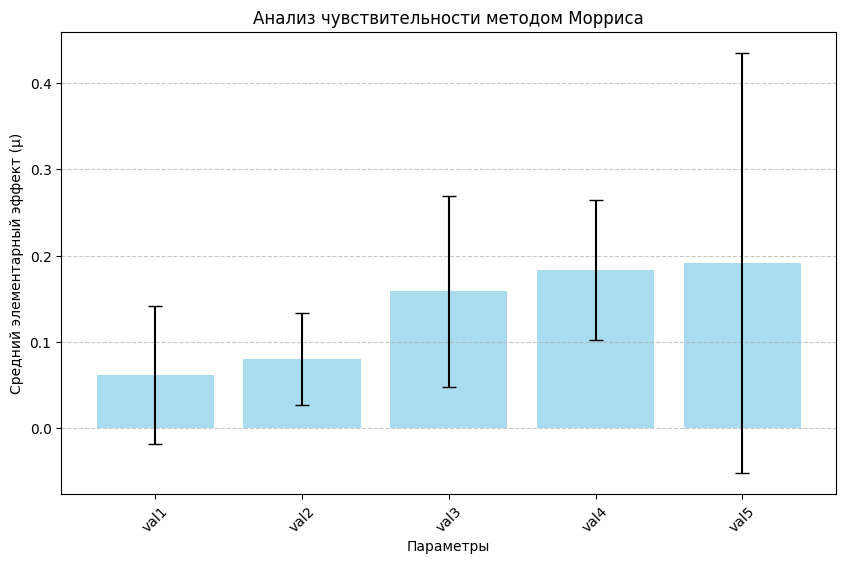

({'val1': np.float64(0.06176051517808817),
  'val2': np.float64(0.0802393595193032),
  'val3': np.float64(0.15845592395244928),
  'val4': np.float64(0.18338861138562607),
  'val5': np.float64(0.19160654402937027)},
 {'val1': np.float64(0.07996706316660544),
  'val2': np.float64(0.05324885914211201),
  'val3': np.float64(0.11048123032193205),
  'val4': np.float64(0.08143967125836836),
  'val5': np.float64(0.24362844203588074)})

In [ ]:
morris_analysis_plot(ee_results)

In [ ]:
ranges

{'val1': (-2.5155084151391285, 2.065079170072512),
 'val2': (-2.5155084151391285, 2.065079170072512),
 'val3': (-2.5155084151391285, 2.065079170072512),
 'val4': (-2.5155084151391285, 2.065079170072512),
 'val5': (-2.5155084151391285, 2.065079170072512)}

In [ ]:
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd

problem = {
    'num_vars': 5,
    'names': ['0', '1', '2', '3', '4'],
    'bounds': list(ranges.values())
}

In [ ]:
N = 1000  # Число выборок
param_values = saltelli.sample(problem, N, calc_second_order=True)

In [ ]:
nominal_point = X_scalled.iloc[0].values

Y = pipeline.predict(param_values)

sobol_results = sobol.analyze(problem, Y, print_to_console=False)

results_df = pd.DataFrame({
    'Parameter': problem['names'],
    'S1': sobol_results['S1'],  # Индексы первого порядка
    'S1_conf': sobol_results['S1_conf'],  # Доверительные интервалы для S1
    'ST': sobol_results['ST'],  # Полные индексы
    'ST_conf': sobol_results['ST_conf']  # Доверительные интервалы для ST
})

# Вывод результатов
print("Индексы чувствительности Соболя:")
print(results_df)

# Анализ устойчивости и чувствительности
print("\nВыводы:")
for i, param in enumerate(problem['names']):
    s1 = sobol_results['S1'][i]
    st = sobol_results['ST'][i]
    print(f"{param}:")
    print(f"  - Вклад первого порядка (S1): {s1:.3f} (влияние без взаимодействий)")
    print(f"  - Полный вклад (ST): {st:.3f} (включая взаимодействия)")
    if s1 > 0.3:
        print(f"  - {param} имеет сильное влияние на выход модели.")
    elif s1 > 0.1:
        print(f"  - {param} имеет умеренное влияние на выход модели.")
    else:
        print(f"  - {param} имеет слабое влияние на выход модели.")
    if st - s1 > 0.1:
        print(f"  - {param} участвует в значительных взаимодействиях с другими параметрами.")
    else:
        print(f"  - Взаимодействия {param} с другими параметрами минимальны.")

y_var = np.var(Y)
print(f"\nДисперсия выхода модели: {y_var:.3f}")
if y_var < 0.1:
    print("Модель устойчива: небольшие вариации параметров вызывают малую дисперсию выхода.")
elif y_var < 1.0:
    print("Модель умеренно устойчива: вариации параметров вызывают умеренную дисперсию выхода.")
else:
    print("Модель неустойчива: вариации параметров вызывают значительную дисперсию выхода.")

Индексы чувствительности Соболя:
  Parameter        S1   S1_conf        ST   ST_conf
0         0  0.013660  0.014621  0.021754  0.002608
1         1  0.062162  0.025065  0.070068  0.007742
2         2  0.109166  0.029415  0.115697  0.009948
3         3  0.167667  0.037326  0.170584  0.013836
4         4  0.632367  0.060301  0.633671  0.060909

Выводы:
0:
  - Вклад первого порядка (S1): 0.014 (влияние без взаимодействий)
  - Полный вклад (ST): 0.022 (включая взаимодействия)
  - 0 имеет слабое влияние на выход модели.
  - Взаимодействия 0 с другими параметрами минимальны.
1:
  - Вклад первого порядка (S1): 0.062 (влияние без взаимодействий)
  - Полный вклад (ST): 0.070 (включая взаимодействия)
  - 1 имеет слабое влияние на выход модели.
  - Взаимодействия 1 с другими параметрами минимальны.
2:
  - Вклад первого порядка (S1): 0.109 (влияние без взаимодействий)
  - Полный вклад (ST): 0.116 (включая взаимодействия)
  - 2 имеет умеренное влияние на выход модели.
  - Взаимодействия 2 с другим